In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from functools import partial
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import tqdm

# Задание 1 

Жидкие продукты разливается в пакеты на линии упаковки. Затраты на подвоз 700 у.е. Совокупная потребность в этих продуктах составляет 140 000 литров в месяц. Стоимость хранения 1 литра в течение месяца составляет 4 у.е. Определить оптимальные параметры пополнения склада цеха разлива.

Включим элемент случайности в этот параметр. Пусть скорость расходования за какой-то промежуток времени (его определите сами) случайным образом меняется. В этом случае у Вас может образоваться дефицит (отсутствие товара на складе) или переполнение склада (довоз товара еще при его наличии). Чтобы оценить эффективность Вашего управления введите еще одну экономическую характеристику — доход от реализации единицы товара. Объясните, почему на прошлом занятии мы не нуждались в такой характеристике. Постройте график состояния склада за три месяца, а также график дохода. Как, используя статистический анализ, снизить потери.

In [2]:
df = pd.DataFrame(columns=['Потребление',
                                                            'Баланс Склада №1',
                                                            'Баланс Склада №2',
                                                            'Расходы №1',
                                                            'Расходы №2',
                                                            'Продаж №1',
                                                            'Продаж №2',
                                                           'Точки закупок №1',
                                                           'Точки закупок №2'])
df['Потребление'] = 5000 + 3000*np.random.randn(90)
df['mean'] = df['Потребление'].expanding().mean()
df['std'] = df['Потребление'].expanding().std()
df = df.fillna(0)
df.head()

,Потребление,Баланс Склада №1,Баланс Склада №2,Расходы №1,Расходы №2,Продаж №1,Продаж №2,Точки закупок №1,Точки закупок №2,mean,std
0,4529.409625,0,0,0,0,0,0,0,0,4529.409625,0.000000
1,4441.762274,0,0,0,0,0,0,0,0,4485.585950,61.976037
2,4620.540209,0,0,0,0,0,0,0,0,4530.570703,89.394623
3,3445.863435,0,0,0,0,0,0,0,0,4259.393886,547.243148
4,10243.169787,0,0,0,0,0,0,0,0,5456.149066,2717.668322


In [3]:
q = 14000
p = 4

In [4]:
for index, row in tqdm.tqdm_notebook(df.iterrows()):
    if index == 0:
        df.loc[index, 'Баланс Склада №1'] = q
        df.loc[index, 'Баланс Склада №2'] = q
    else:
        df.loc[index, 'Продаж №1'] = min(df.loc[index-1, 'Баланс Склада №1'], row['Потребление'])
        df.loc[index, 'Продаж №2'] = min(df.loc[index-1, 'Баланс Склада №2'], row['Потребление'])
        
        df.loc[index, 'Баланс Склада №1'] = df.loc[index-1, 'Баланс Склада №1'] - df.loc[index, 'Продаж №1']
        if index%3==0:
            df.loc[index, 'Баланс Склада №1'] = df.loc[index, 'Баланс Склада №1'] + q
            df.loc[index, 'Расходы №1'] = -700
            df.loc[index, 'Точки закупок №1'] = 1
        
        df.loc[index, 'Баланс Склада №2'] = df.loc[index-1, 'Баланс Склада №2'] - df.loc[index, 'Продаж №2']
        if (df.loc[index, 'Баланс Склада №2'] < row['mean']):
            df.loc[index, 'Баланс Склада №2'] = row['mean'] + 3*row['std']
            df.loc[index, 'Расходы №2'] = -700
            df.loc[index, 'Точки закупок №2'] = 1
        
        df.loc[index, 'Расходы №1'] = df.loc[index, 'Расходы №1'] - df.loc[index, 'Баланс Склада №1']*4/30 + df.loc[index, 'Продаж №1']*p
        df.loc[index, 'Расходы №2'] = df.loc[index, 'Расходы №2'] - df.loc[index, 'Баланс Склада №2']*4/30 + df.loc[index, 'Продаж №2']*p

In [5]:
df['Расходы №2'].sum() / df['Расходы №1'].sum()

1.042897585346229

склад переполняется $=>$ доход фирмы снижается

<IPython.core.display.Javascript object>


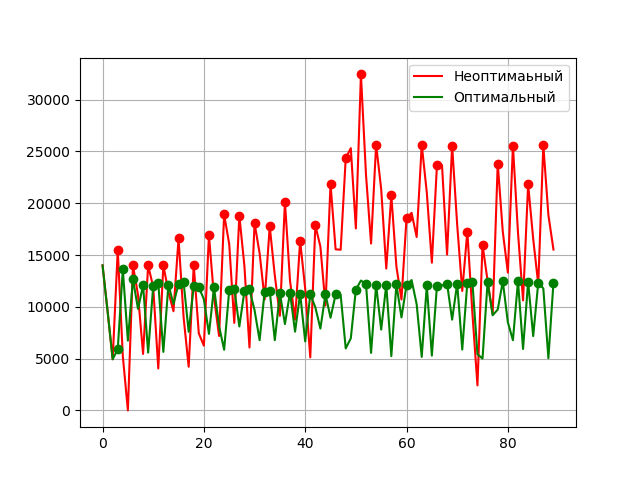

In [7]:
plt.figure()
plt.plot(df.index, df['Баланс Склада №1'], 'r')
plt.plot(df.index, df['Баланс Склада №2'], 'g')

y = np.array(range(len(df)))[df['Точки закупок №1'] == 1]
plt.plot(y, df['Баланс Склада №1'].iloc[y], 'ro')

y = np.array(range(len(df)))[df['Точки закупок №2'] == 1]
plt.plot(y, df['Баланс Склада №2'].iloc[y], 'go')
    
plt.grid()
plt.show()
plt.legend(['Неоптимаьный', 'Оптимальный'])

<IPython.core.display.Javascript object>


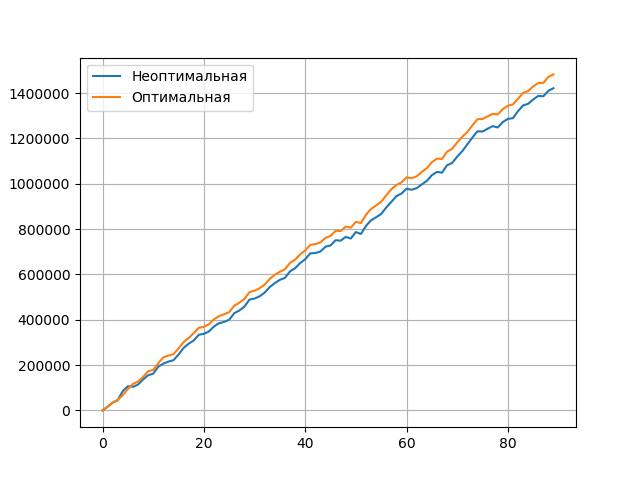

In [6]:
plt.figure()
plt.grid()
plt.plot(np.cumsum(df['Расходы №1']))
plt.plot(np.cumsum(df['Расходы №2']))
plt.legend(['Неоптимальная', 'Оптимальная'])

## Задание 2

In [8]:
N = 90
t = np.linspace(0, 0+N, N+1)
df = pd.DataFrame(columns=['Потребление',
                                                            'Баланс Склада №1',
                                                            'Баланс Склада №2',
                                                            'Расходы №1',
                                                            'Расходы №2',
                                                            'Продаж №1',
                                                            'Продаж №2',
                                                           'Точки закупок №1',
                                                           'Точки закупок №2'])
df['Потребление'] = 1000 + (100*(0.1*t + np.cos(t/7*2*np.pi) + 100*np.random.randn(N+1))).astype(np.int)
df['mean'] = df['Потребление'].rolling(window=7).mean()
df['std'] = df['Потребление'].expanding().std()
df = df.fillna(0)
df.head()

,Потребление,Баланс Склада №1,Баланс Склада №2,Расходы №1,Расходы №2,Продаж №1,Продаж №2,Точки закупок №1,Точки закупок №2,mean,std
0,-15222,0,0,0,0,0,0,0,0,0.0,0.000000
1,3087,0,0,0,0,0,0,0,0,0.0,12946.418057
2,-2959,0,0,0,0,0,0,0,0,0.0,9328.761672
3,-4797,0,0,0,0,0,0,0,0,0.0,7617.803112
4,1747,0,0,0,0,0,0,0,0,0.0,7249.427646


In [9]:
q = 14000
p = 4

In [10]:
for index, row in tqdm.tqdm_notebook(df.iterrows()):
    if index == 0:
        df.loc[index, 'Баланс Склада №1'] = q
        df.loc[index, 'Баланс Склада №2'] = q
    else:
        df.loc[index, 'Продаж №1'] = min(df.loc[index-1, 'Баланс Склада №1'], row['Потребление'])
        df.loc[index, 'Продаж №2'] = min(df.loc[index-1, 'Баланс Склада №2'], row['Потребление'])
        
        df.loc[index, 'Баланс Склада №1'] = df.loc[index-1, 'Баланс Склада №1'] - df.loc[index, 'Продаж №1']
        if index%3==0:
            df.loc[index, 'Баланс Склада №1'] = df.loc[index, 'Баланс Склада №1'] + q
            df.loc[index, 'Расходы №1'] = -700
            df.loc[index, 'Точки закупок №1'] = 1
        
        df.loc[index, 'Баланс Склада №2'] = df.loc[index-1, 'Баланс Склада №2'] - df.loc[index, 'Продаж №2']
        if (df.loc[index, 'Баланс Склада №2'] < row['mean']):
            df.loc[index, 'Баланс Склада №2'] = row['mean'] + 3*row['std']
            df.loc[index, 'Расходы №2'] = -700
            df.loc[index, 'Точки закупок №2'] = 1
        
        df.loc[index, 'Расходы №1'] = df.loc[index, 'Расходы №1'] - df.loc[index, 'Баланс Склада №1']*4/30 + df.loc[index, 'Продаж №1']*p
        df.loc[index, 'Расходы №2'] = df.loc[index, 'Расходы №2'] - df.loc[index, 'Баланс Склада №2']*4/30 + df.loc[index, 'Продаж №2']*p

In [11]:
df['Расходы №2'].sum() / df['Расходы №1'].sum()

-0.6013750978437318

<IPython.core.display.Javascript object>


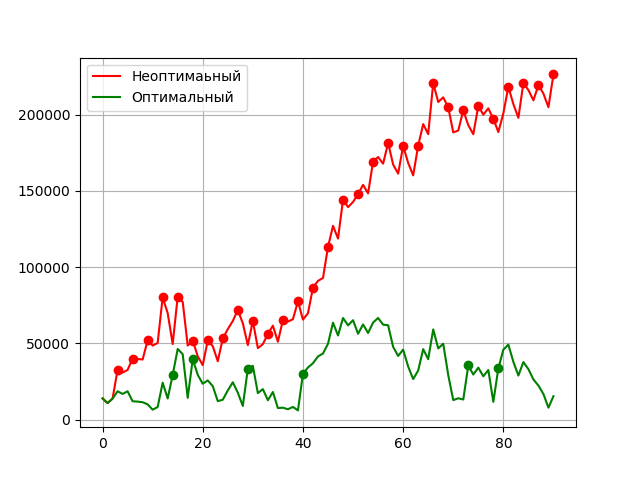

In [12]:
plt.figure()
plt.plot(df.index, df['Баланс Склада №1'], 'r')
plt.plot(df.index, df['Баланс Склада №2'], 'g')

y = np.array(range(len(df)))[df['Точки закупок №1'] == 1]
plt.plot(y, df['Баланс Склада №1'].iloc[y], 'ro')

y = np.array(range(len(df)))[df['Точки закупок №2'] == 1]
plt.plot(y, df['Баланс Склада №2'].iloc[y], 'go')
    
plt.grid()
plt.show()
plt.legend(['Неоптимаьный', 'Оптимальный'])

склад переполняется $=>$ доход фирмы снижается

<IPython.core.display.Javascript object>


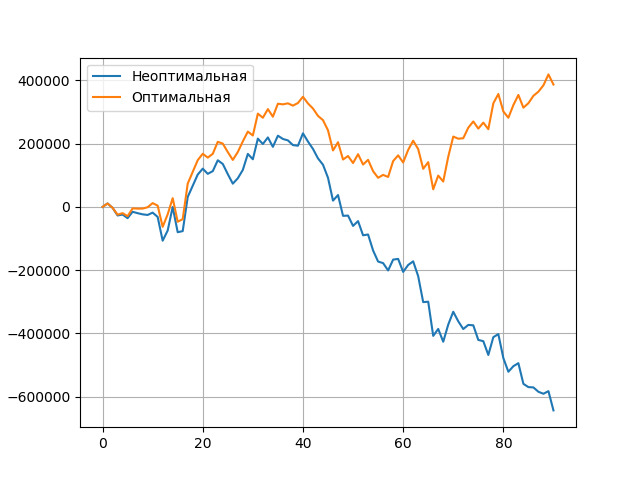

In [13]:
plt.figure()
plt.grid()
plt.plot(np.cumsum(df['Расходы №1']))
plt.plot(np.cumsum(df['Расходы №2']))
plt.legend(['Неоптимальная', 'Оптимальная'])